
# Heart Disease — Neural Network Scaling & Normalization Experiments

In [1]:
import os, math, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow:", tf.__version__)
print("Pandas:", pd.__version__)


TensorFlow: 2.20.0
Pandas: 2.3.2


## Configuration

In [2]:
DATA_PATH = "heart.csv"  

NUMERIC_COLS = ["age","trestbps","chol","thalach","oldpeak"]
CATEGORICAL_COLS = ["sex","cp","fbs","restecg","exang","slope","ca","thal"]
TARGET_COL = "target"
RANDOM_STATE = 42
EPOCHS = 100
BATCH_SIZE = 32
PATIENCE = 15  
VERBOSE = 0    

LR_GRID = [1e-4, 1e-3, 1e-2]


## Load Data & Quick EDA

In [3]:

assert os.path.exists(DATA_PATH), f"Could not find {DATA_PATH}. Please upload it next to this notebook."

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print("\nColumns:", list(df.columns))
print("\nHead:")
display(df.head())

# Basic target distribution
print("\nTarget distribution:")
print(df[TARGET_COL].value_counts(dropna=False))

# Check dtypes and missing values
print("\nDtypes:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isna().sum())

# Basic numeric summary
display(df.describe(include="all"))


Shape: (1025, 14)

Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

Head:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0



Target distribution:
target
1    526
0    499
Name: count, dtype: int64

Dtypes:
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


## Model Factory

In [4]:

def build_mlp(input_dim: int, lr: float = 1e-3) -> keras.Model:
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
    return model


In [5]:

def train_and_eval(X, y, description: str, lr: float = 1e-3):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )

    model = build_mlp(X_train.shape[1], lr=lr)
    es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)
    hist = model.fit(
        X_train, y_train, validation_split=0.2,
        epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], verbose=VERBOSE
    )

    # Convergence speed proxy: epoch index of min val_loss
    val_losses = hist.history["val_loss"]
    best_epoch = int(np.argmin(val_losses)) + 1  # 1-indexed

    # Evaluate
    y_pred_prob = model.predict(X_test, verbose=0).ravel()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)

    results = {
        "setup": description,
        "learning_rate": lr,
        "best_epoch": best_epoch,
        "test_accuracy": acc,
        "test_precision": prec,
        "test_recall": rec,
        "history": hist.history
    }
    return results


## Preprocessing Variants

In [6]:
# Prepare X, y 
df_proc = df.copy()
for c in CATEGORICAL_COLS:
    if c in df_proc.columns:
        df_proc[c] = df_proc[c].astype("category")

X_full = df_proc.drop(columns=[TARGET_COL])
y = df_proc[TARGET_COL].astype(int).values

def design_matrix(raw_df: pd.DataFrame, one_hot: bool, scaler: str):
  
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

    numeric = [c for c in NUMERIC_COLS if c in raw_df.columns]
    categorical = [c for c in CATEGORICAL_COLS if c in raw_df.columns]

    transformers = []
    # numeric
    if scaler == "minmax":
        transformers.append(("num", MinMaxScaler(), numeric))
    elif scaler == "standard":
        transformers.append(("num", StandardScaler(), numeric))
    else:
        transformers.append(("num", "passthrough", numeric))

    # categorical
    if one_hot and len(categorical) > 0:
        transformers.append(("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical))
    else:
        # convert categorical to integer codes deterministically
        tmp = raw_df[categorical].apply(lambda s: s.cat.codes if hasattr(s, "cat") else s)
        raw_df = raw_df.drop(columns=categorical).join(tmp.rename(columns={c: c for c in categorical}))
        transformers.append(("cat", "passthrough", categorical))

    ct = ColumnTransformer(transformers=transformers, remainder="drop", sparse_threshold=0.0)
    X = ct.fit_transform(raw_df)

    try:
        if one_hot and len(categorical) > 0:
            ohe = [t for t in ct.transformers_ if t[0] == "cat"][0][1]
            cat_names = ohe.get_feature_names_out(categorical).tolist()
        else:
            cat_names = categorical
        feature_names = numeric + cat_names
    except Exception:
        feature_names = [f"f{i}" for i in range(X.shape[1])]

    return X.astype(np.float32), feature_names

# Build all experiment matrices
variants = []
for one_hot in [False, True]:
    for scaler in ["none", "minmax", "standard"]:
        X_mat, feat_names = design_matrix(X_full.copy(), one_hot=one_hot, scaler=scaler)
        variants.append({
            "desc": f"{'OHE' if one_hot else 'Label'} | {scaler}",
            "X": X_mat,
            "features": feat_names,
            "one_hot": one_hot,
            "scaler": scaler
        })

print("Variants:", [v["desc"] for v in variants])


Variants: ['Label | none', 'Label | minmax', 'Label | standard', 'OHE | none', 'OHE | minmax', 'OHE | standard']


## Experiments: Base Learning Rate (1e-3)

In [7]:

base_lr = 1e-3
results = []
for v in variants:
    res = train_and_eval(v["X"], y, description=v["desc"], lr=base_lr)
    results.append(res)

res_df = pd.DataFrame([{
    "Setup": r["setup"],
    "LR": r["learning_rate"],
    "BestEpoch": r["best_epoch"],
    "Accuracy": r["test_accuracy"],
    "Precision": r["test_precision"],
    "Recall": r["test_recall"],
} for r in results]).sort_values(["Accuracy","Precision","Recall","BestEpoch"], ascending=[False, False, False, True]).reset_index(drop=True)

display(res_df)


,Setup,LR,BestEpoch,Accuracy,Precision,Recall
0,Label | standard,0.001,100,1.000000,1.000000,1.000000
1,OHE | minmax,0.001,100,1.000000,1.000000,1.000000
2,OHE | standard,0.001,100,1.000000,1.000000,1.000000
3,Label | minmax,0.001,100,0.960976,0.953271,0.971429
4,OHE | none,0.001,22,0.873171,0.843478,0.923810
5,Label | none,0.001,57,0.858537,0.822034,0.923810


### Validation Loss Curves (per variant)

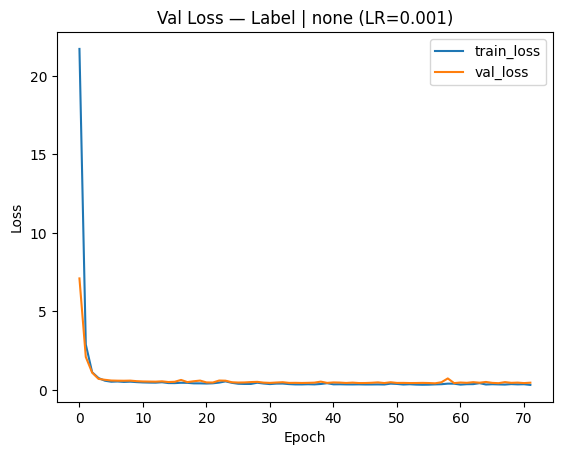

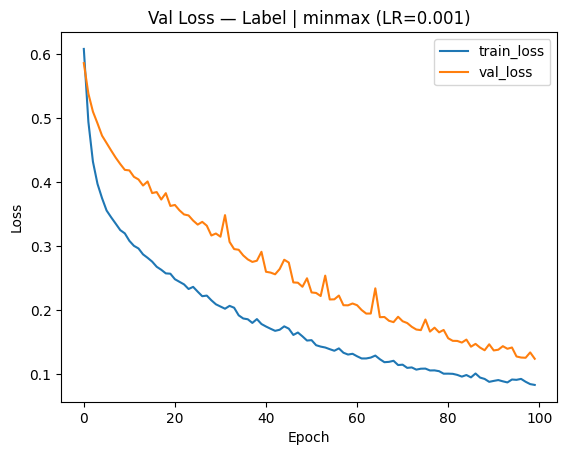

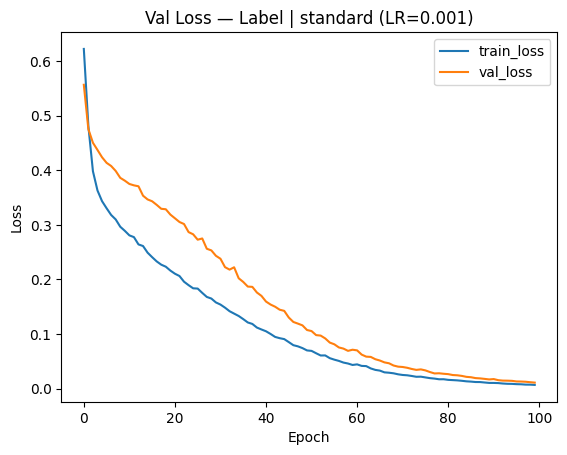

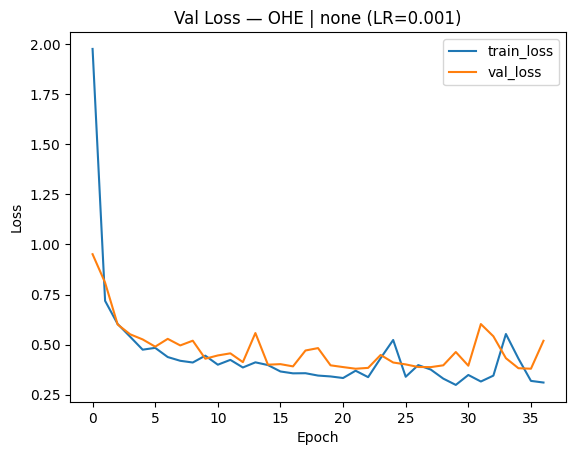

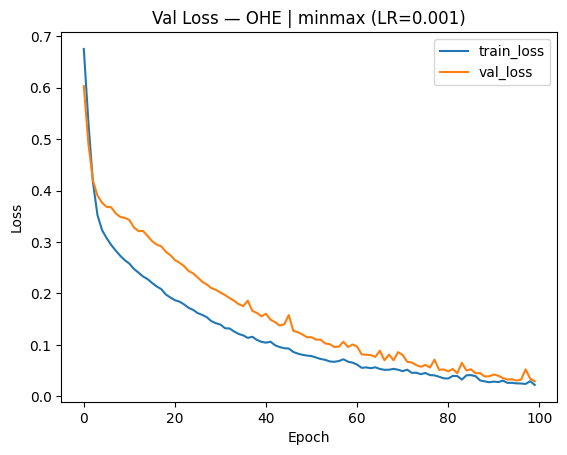

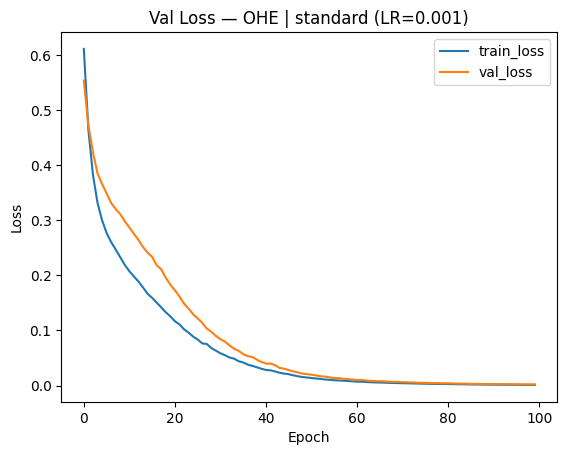

In [8]:

for r in results:
    plt.figure()
    plt.plot(r["history"]["loss"], label="train_loss")
    plt.plot(r["history"]["val_loss"], label="val_loss")
    plt.title(f"Val Loss — {r['setup']} (LR={r['learning_rate']})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


## Learning-Rate Sensitivity

In [9]:

# Choose two representative setups:
X_unscaled = [v for v in variants if v["desc"] == "Label | none"][0]["X"]
X_scaled_ohe = [v for v in variants if v["desc"] == "OHE | standard"][0]["X"]

lr_sensitivity = []

for lr in [1e-4, 1e-3, 1e-2]:
    lr_sensitivity.append(train_and_eval(X_unscaled, y, description=f"Unscaled(Label) LR={lr}", lr=lr))
for lr in [1e-4, 1e-3, 1e-2]:
    lr_sensitivity.append(train_and_eval(X_scaled_ohe, y, description=f"Standard+OHE LR={lr}", lr=lr))

sens_df = pd.DataFrame([{
    "Setup": r["setup"],
    "LR": r["learning_rate"],
    "BestEpoch": r["best_epoch"],
    "Accuracy": r["test_accuracy"],
    "Precision": r["test_precision"],
    "Recall": r["test_recall"]
} for r in lr_sensitivity]).sort_values(["Setup","LR"]).reset_index(drop=True)

display(sens_df)


,Setup,LR,BestEpoch,Accuracy,Precision,Recall
0,Standard+OHE LR=0.0001,0.0001,100,0.902439,0.889908,0.923810
1,Standard+OHE LR=0.001,0.0010,100,1.000000,1.000000,1.000000
2,Standard+OHE LR=0.01,0.0100,100,1.000000,1.000000,1.000000
3,Unscaled(Label) LR=0.0001,0.0001,100,0.819512,0.783333,0.895238
4,Unscaled(Label) LR=0.001,0.0010,56,0.829268,0.782258,0.923810
5,Unscaled(Label) LR=0.01,0.0100,31,0.858537,0.811475,0.942857


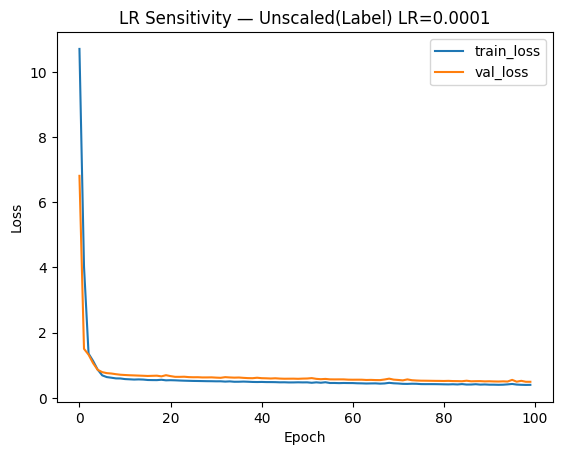

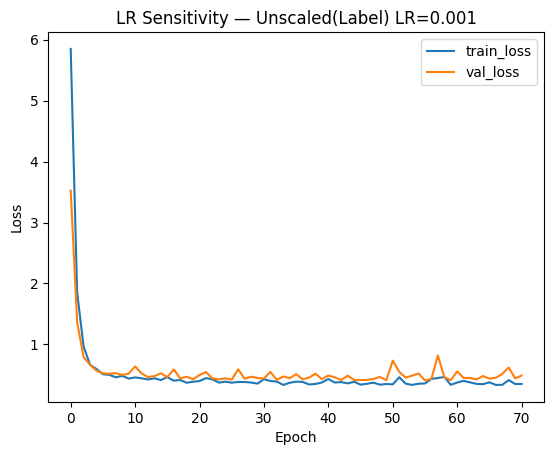

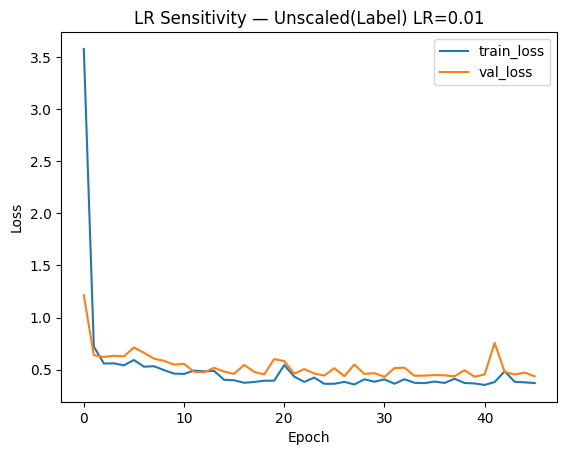

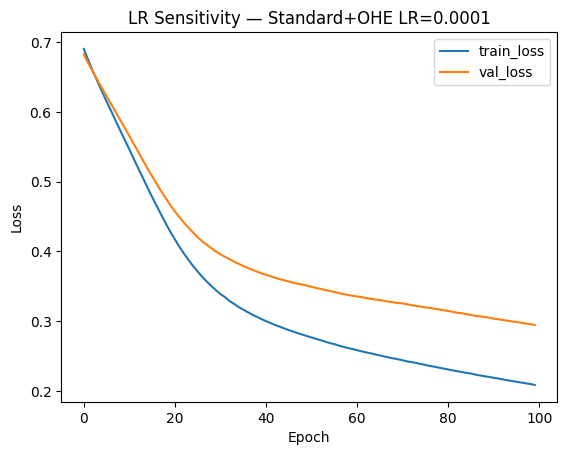

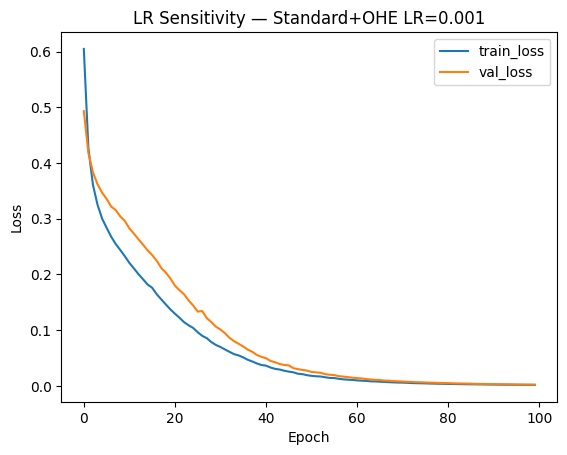

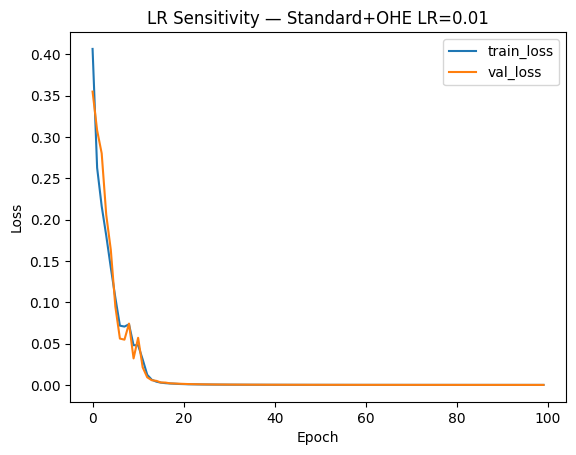

In [10]:

for r in lr_sensitivity:
    plt.figure()
    plt.plot(r["history"]["loss"], label="train_loss")
    plt.plot(r["history"]["val_loss"], label="val_loss")
    plt.title(f"LR Sensitivity — {r['setup']}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
